In [303]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [304]:
import pathlib
data_dir = pathlib.Path("../dataset_images")

In [305]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

783


In [306]:
batch_size = 32
img_width = 160
img_height = 120

colour_mode = "rgb"

seed = 123

In [307]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  color_mode=colour_mode,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 783 files belonging to 40 classes.
Using 627 files for training.


ValueError: 'size' must be a 1-D int32 Tensor

In [283]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  color_mode=colour_mode,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 783 files belonging to 40 classes.
Using 156 files for validation.


In [284]:
class_names = train_ds.class_names
print(class_names)

['value_0', 'value_1', 'value_10', 'value_11', 'value_12', 'value_13', 'value_14', 'value_15', 'value_16', 'value_17', 'value_18', 'value_19', 'value_2', 'value_20', 'value_21', 'value_22', 'value_23', 'value_24', 'value_25', 'value_26', 'value_27', 'value_28', 'value_29', 'value_3', 'value_30', 'value_31', 'value_32', 'value_33', 'value_34', 'value_35', 'value_36', 'value_37', 'value_38', 'value_39', 'value_4', 'value_5', 'value_6', 'value_7', 'value_8', 'value_9']


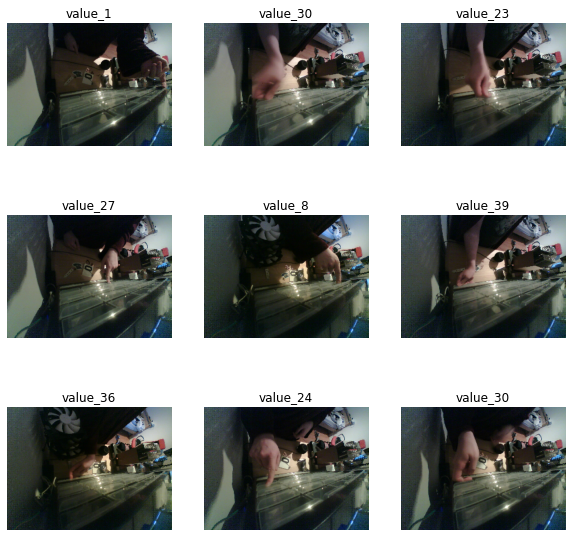

In [285]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [286]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [287]:
num_classes = len(class_names)

factor = 1

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(factor * 2, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
#   layers.Conv2D(factor * 4, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(factor * 8, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [288]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [289]:
# model.summary()

In [290]:
epochs=60
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/60
20/20 [==============================] - 7s 364ms/step - loss: 3.5580 - accuracy: 0.1627 - val_loss: 3.3128 - val_accuracy: 0.2308
Epoch 2/60
20/20 [==============================] - 5s 227ms/step - loss: 3.3316 - accuracy: 0.1834 - val_loss: 3.1551 - val_accuracy: 0.2308
Epoch 3/60
20/20 [==============================] - 5s 231ms/step - loss: 3.1293 - accuracy: 0.1882 - val_loss: 3.0794 - val_accuracy: 0.2436
Epoch 4/60
20/20 [==============================] - 5s 237ms/step - loss: 3.0596 - accuracy: 0.1866 - val_loss: 2.9804 - val_accuracy: 0.2372
Epoch 5/60
20/20 [==============================] - 5s 248ms/step - loss: 2.9711 - accuracy: 0.1850 - val_loss: 2.8858 - val_accuracy: 0.2308
Epoch 6/60
20/20 [==============================] - 5s 244ms/step - loss: 2.8393 - accuracy: 0.1898 - val_loss: 2.8289 - val_accuracy: 0.2500
Epoch 7/60
20/20 [==============================] - 5s 251ms/step - loss: 2.7491 - accuracy: 0.2010 - val_loss: 2.7696 - val_accuracy: 0.2436
Epoch 

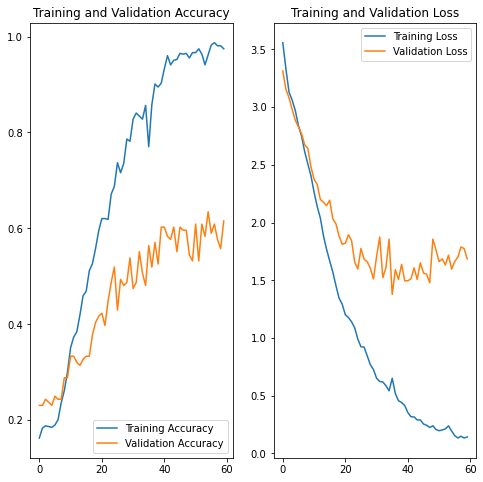

In [291]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [292]:
from tinymlgen import port
c_code = port(model, pretty_print=True, optimize=True)
print(c_code)

0x01, 0x00, 0xfe, 0x02, 0xfe, 
	0xfe, 0xff, 0x02, 0x00, 0xfe, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0xfe, 
	0xff, 0x01, 0x00, 0x01, 0xfe, 0x01, 0x01, 0xff, 0x01, 0x01, 0x00, 0xff, 
	0x01, 0xfd, 0x02, 0xfe, 0xff, 0xff, 0x01, 0x01, 0x02, 0xff, 0x02, 0xff, 
	0x00, 0xff, 0x01, 0x00, 0x01, 0xff, 0x02, 0x00, 0xfe, 0x01, 0xfe, 0x00, 
	0x01, 0xff, 0x01, 0xfe, 0xfe, 0xff, 0x00, 0x00, 0xff, 0x00, 0xfe, 0xfe, 
	0x00, 0x01, 0x00, 0xff, 0x00, 0xff, 0x02, 0x00, 0x00, 0x01, 0x00, 0x01, 
	0x00, 0xff, 0xfe, 0x01, 0xff, 0x00, 0x00, 0x00, 0x00, 0xfd, 0xff, 0xff, 
	0xff, 0xff, 0xff, 0x00, 0x01, 0xff, 0x01, 0xff, 0x01, 0x00, 0xfe, 0xfe, 
	0x01, 0x00, 0x02, 0x00, 0x01, 0xfd, 0x01, 0xfe, 0xfe, 0x00, 0xff, 0xfd, 
	0x01, 0xfd, 0xff, 0xff, 0x01, 0xff, 0xfe, 0xfe, 0xff, 0xff, 0x02, 0xfe, 
	0x01, 0x01, 0x01, 0x00, 0xfe, 0xfe, 0x01, 0xfe, 0x00, 0xfe, 0x02, 0xff, 
	0x00, 0x01, 0xff, 0xff, 0xff, 0xff, 0x01, 0xff, 0xfe, 0xfe, 0x01, 0x00, 
	0x00, 0x00, 0x00, 0x00, 0xf6, 0xfd, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 
	0x04, 